# Run Camera Calibration to Remove Effect of MTF

The Camera System including lens, sensor, and early pipeline processing does not necessarily have an equal effect on all spatial frequencies - some could be more dampened more than others and some could be boosted. Given that the Spatiotemporal Power Spectrum measure The Modulation Transfer Function describes this effect

## Dependencies

In [1]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import math
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 5.0)
import utils.bins_to_pngs as bin2png
import stftoolkit as stf

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/hmet_data/feb2021/'
trial_num = '001'
data_dir = os.path.join(base_dir, 'raw', '2021_02_19', trial_num)
#output_dir = os.path.join(base_dir, 'analysis', 'mtf', trial_num)
#output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 400

reconvert=False

## Specify Directories for Exmaple

In [3]:
example_trial = 'calib_mtf/calib'
iteration = trial_num
#trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, iteration)
save_dir = os.path.join('./output', example_trial, iteration)

try:
    os.makedirs(save_dir)
    os.makedirs(pngs_dir)
except:
    print(f'{save_dir} already made!')

#analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
#common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


./output/calib_mtf/calib/001 already made!


## Convert Frames to PNGS

In [4]:
binfilename = os.path.join(data_dir,'ximea','ximea',f'frames_0_{save_batchsize-1}.bin')
first_fnum = 0
if(reconvert):
    bin2png.convert_bin_pngs(binfilename, first_fnum, save_batchsize, pngs_dir)
else:
    print('Skipping conversion step!')

Skipping conversion step!


## Read in Imaged Edge

In [5]:
pngs_dir

'/hmet_data/feb2021/pngs/calib_mtf/calib/001'

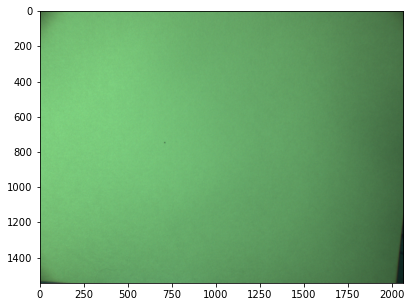

In [6]:
i=30
frame = cv2.imread(os.path.join(pngs_dir, f'frame_{i}.png'))
plt.imshow(frame)

## Remove Image Warping
Read in Camera Matrix and Distortion Matrix as measured with checkerboard pattern to remove camera distortion

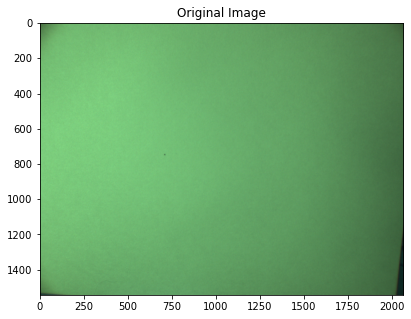

Text(0.5, 1.0, 'Undistorted Image')

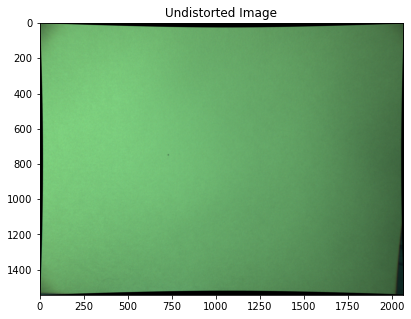

In [11]:
calibration_fname = os.path.join('/','hmet_data','calibration', 'analysis',"calibration_ximea_distortion.yaml")

with open(calibration_fname) as f:
    loadeddict = yaml.load(f, Loader=yaml.BaseLoader)
mtx = np.asarray(loadeddict.get('camera_matrix'), dtype='float32')
dist = np.asarray(loadeddict.get('dist_coeff'), dtype='float32')

h, w = frame.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

frame_undistorted = cv2.undistort(frame, mtx, dist, None, newcameramtx)
plt.imshow(frame)
plt.title('Original Image')
plt.show()
plt.imshow(frame_undistorted)
plt.title('Undistorted Image')

## Crop to Remove Edges

Text(0.5, 1.0, 'Undistorted Image')

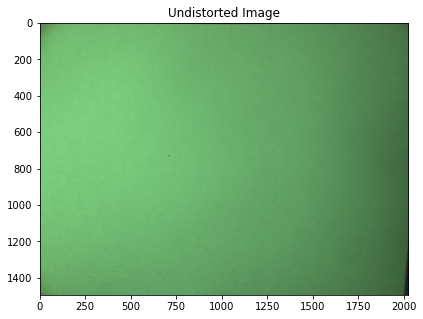

In [12]:
frame_undistorted = frame_undistorted[20:-30,20:-20,:]
plt.imshow(frame_undistorted)
plt.title('Undistorted Image')

## Simple White Balance
I'm not sure if this is strictly necessary for the alignment and subsequent processing but I really don't want to look at this green/yellow image

Lowval:  64
Highval:  125
Lowval:  104
Highval:  208
Lowval:  64
Highval:  127


Text(0.5, 1.0, 'White Balanced Frame')

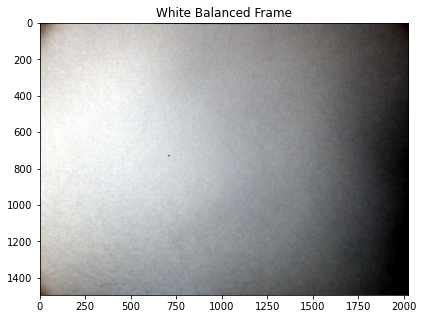

In [13]:
#from https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        print("Lowval: ", low_val)
        print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

wb_frame_undistorted = simplest_cb(frame_undistorted, 3)
plt.imshow(wb_frame_undistorted)
plt.title('White Balanced Frame')

Ok this is much less annoying to look at! Unclear though if this is really the correct algorithm.

## Take mean to make Image Greyscale
Do this for both the white balanced and the original images

Text(0.5, 1.0, 'White Balanced Frame - Greyscale')

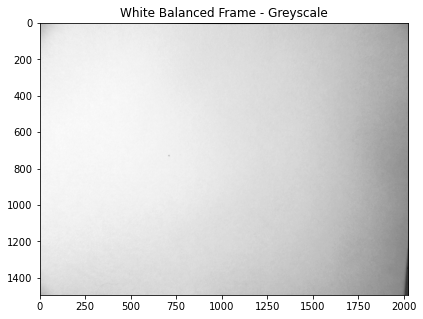

In [14]:
plt.imshow(np.mean(frame_undistorted,axis=-1),cmap='Greys_r')
plt.title('White Balanced Frame - Greyscale')

Text(0.5, 1.0, 'Frame - Greyscale')

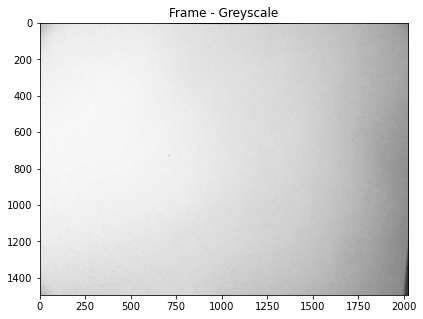

In [15]:
frame_grey = np.mean(frame_undistorted,axis=-1)
plt.imshow(frame_grey,cmap='Greys_r')
plt.title('Frame - Greyscale')

## Create Digital Image

In [18]:
h,w,c = np.shape(frame_undistorted)
digital_image = np.ones((np.shape(frame_undistorted)))
digital_image[h//2, w//2,:] = 0

#from https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

rot_digital_image = rotate_image(digital_image,-1)
rot_digital_image[1000:,:,:] = 1

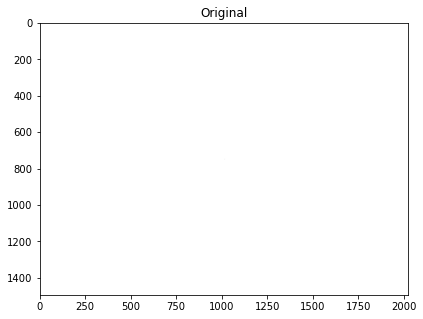

In [20]:
plt.imshow(digital_image,cmap='Greys_r')
plt.title('Original')
plt.show()


## Ensure Distributions Match

Text(0.5, 1.0, 'Pre Normalization')

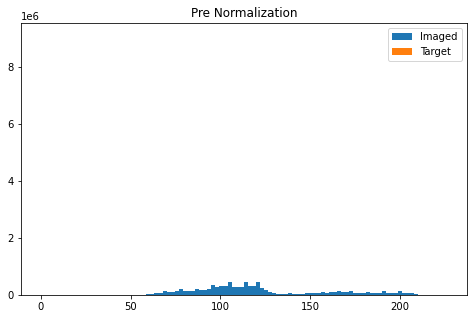

In [21]:
plt.hist(frame_undistorted.flatten(), bins=100, label='Imaged');
plt.hist(digital_image.flatten(), bins=100, label='Target');
plt.legend()
plt.title('Pre Normalization')

Text(0.5, 1.0, 'Post Normalization')

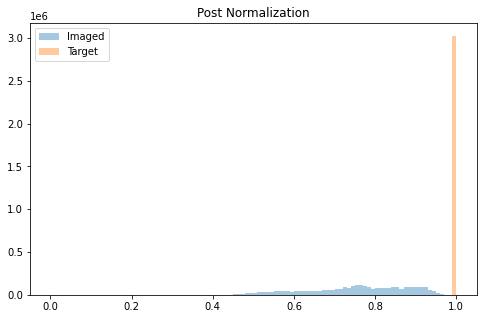

In [23]:
def scale_norm_grey(img):
    img = np.mean(img,axis=-1) #MAKE GREYSCALE
    img = img - np.min(img) #SET MIN TO ZERO
    img = img/np.max(img) #MAX 1
    return(img)
    
imaged = scale_norm_grey(frame_undistorted)
target = scale_norm_grey(digital_image)
plt.hist(imaged.flatten(), bins=100, label='Imaged', alpha=0.4);
plt.hist(target.flatten(), bins=100, label='Target', alpha=0.4);
plt.legend()
plt.title('Post Normalization')

(<AxesSubplot:title={'center':'Target'}>,
 Text(0.5, 1.0, 'Target'))

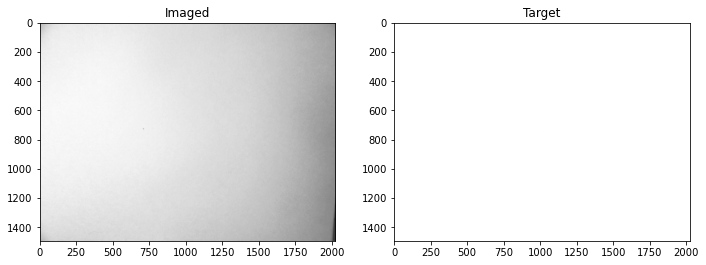

In [24]:
plt.figure(figsize=(18,6))
plt.subplot(131),plt.imshow(imaged,cmap='Greys_r'),plt.title('Imaged')
plt.subplot(132),plt.imshow(target,cmap='Greys_r'),plt.title('Target')

## Compare FFTs of Original and Imaged Stars

In [25]:
def spatialft(image, cosine_window=True, rmdc=True, power=True):
    """Take the fourier transform of an image (or flow field).
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""

    #remove color dimension
    if(image.ndim >2):
        image = np.mean(image,axis=-1)
    
    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    if(cosine_window):
        cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
        image = image * cosfilter
    
    # remove DC component
    if(rmdc):
        image =  image - np.mean(image)
    
    spec = np.fft.fftshift(np.fft.fft2(image))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(image)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(image)[1]))]

    if power:
        return(np.abs(spec)**2, fqs)
    else:
        return(spec, fqs)

In [32]:
star_target_ps, fqs = spatialft(target, cosine_window=True)
star_imaged_ps, fqs = spatialft(imaged, cosine_window=True)

(<AxesSubplot:title={'center':'Imaged Power Spec'}>,
 Text(0.5, 1.0, 'Imaged Power Spec'))

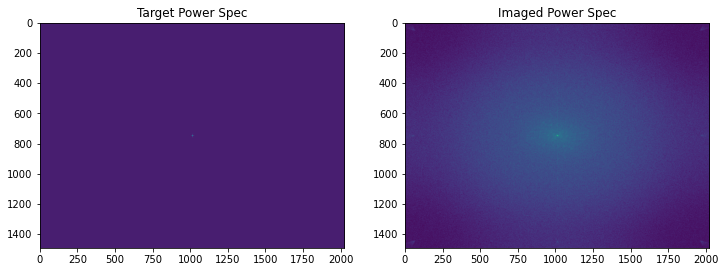

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(np.log10(star_target_ps+0.1)),plt.title('Target Power Spec')
plt.subplot(122),plt.imshow(np.log10(star_imaged_ps+0.1)),plt.title('Imaged Power Spec')

## Infer MTF by Convolution Theorm

(<AxesSubplot:title={'center':'PSF'}>,
 Text(0.5, 1.0, 'PSF'),
 <matplotlib.colorbar.Colorbar at 0x7f4162c4efd0>)

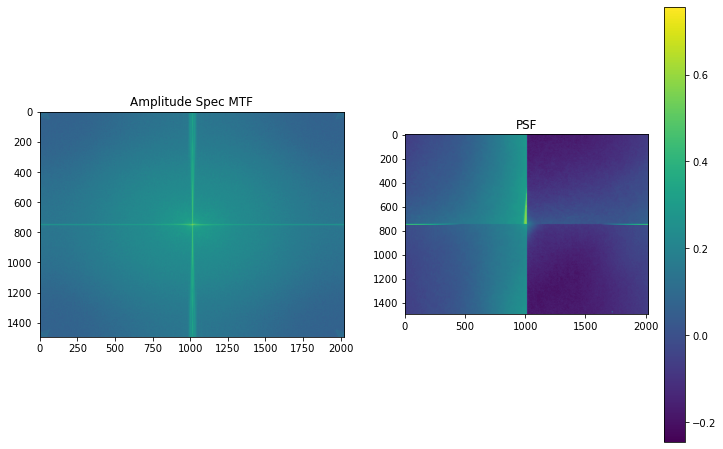

In [28]:
star_target_ft, fqs = spatialft(target+0.1, cosine_window=False, power=False)
star_imaged_ft, fqs = spatialft(imaged+0.1, cosine_window=False, power=False)

mtf2d = star_imaged_ft / star_target_ft
psf2d = np.real(np.fft.ifft2(np.fft.ifftshift(mtf2d)))

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(np.log10(np.abs(mtf2d))),plt.title('Amplitude Spec MTF')
plt.subplot(122),plt.imshow(psf2d),plt.title('PSF'),plt.colorbar()


# Collapse to 1D - Power Spectrum

Need to average over power spectra (not amplitude or FT directly - but thyen how can we invert and get MTF?)

In [29]:
#fqs are in cycles per image, convert to cycles per degree
# cycles per image (longest dim)
#ximea speec params
img_dims = (1544,2064)
horizontal_fov_deg = 61.
horiz_ppd = img_dims[1]/horizontal_fov_deg

Text(0.5, 1.0, 'Azimuthal Averaged Power Spectra')

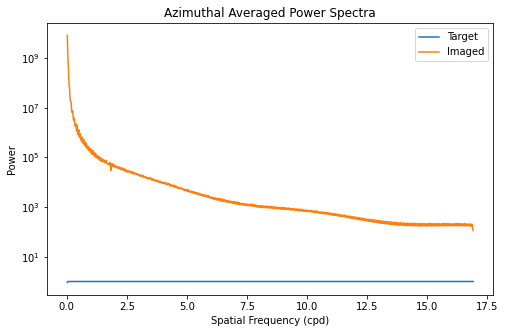

In [30]:
# plt.imshow(np.log(star_img_ps - star_transformed_ps + 0.0001))
# plt.title('Difference')
# plt.colorbar()
star_target_ps_avg, fqs1d_cpp = stf.azimuthalAverage(star_target_ps, 0.5, bin_in_log=False)
star_imaged_ps_avg, fqs1d_cpp = stf.azimuthalAverage(star_imaged_ps, 0.5, bin_in_log=False)

fqs_cpd = fqs1d_cpp * horiz_ppd

plt.plot(fqs_cpd, star_target_ps_avg,label='Target')
plt.plot(fqs_cpd, star_imaged_ps_avg,label='Imaged')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Power')
plt.legend()
plt.title('Azimuthal Averaged Power Spectra')


## Infer MTF by Convolution Theorm

This is not currently Acutally the MTF because it the the ratio of the power spectra, not the FTs.

Text(0.5, 1.0, 'Calculated Power Spectrum Transfer Function')

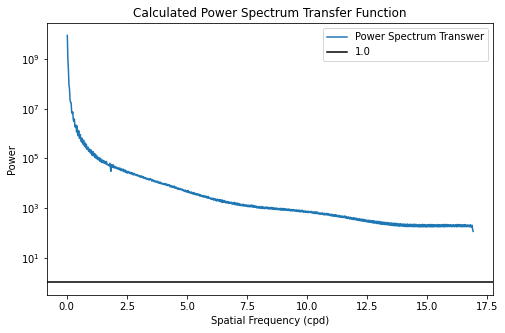

In [31]:
star_target_ft, fqs = spatialft(target, cosine_window=False, power=False)
star_imaged_ft, fqs = spatialft(imaged, cosine_window=False, power=False)

mtf = star_imaged_ps_avg / star_target_ps_avg
plt.plot(fqs_cpd, mtf, label='Power Spectrum Transwer')
plt.axhline(1.0, c='k', label='1.0')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Power')
plt.legend()
plt.title('Calculated Power Spectrum Transfer Function')

In [24]:
{}

{}